# Fingerprint GAN Research

This document contains some of the work for my Master's from 2021, which I never finished. I ended up lossig some of my work, so I had to create it. 

## Introduction

An open problem in the area of Latent Fingerprint Recognition is the enhancement of poor quality fingerprints for the purpose of improving fingerprint matching accuracy. Although there a lots of algorithms out there to enhance fingerprint images, the results of some of the best solutions are less than satisfactory. For this reason, my research was on the use of Generative Adversarial Networks for the purpose of enhacing images of latent fingerprints for improving matching accuracy.

This GAN was adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. It is similar to traditional GANs.

A common problem with GANs is mode collapse. This can happen if it is trained on multi-modal data or data that contains more than one class. This is the problem that this GAN is having also. The model would appear to start producing images of fingerprints, but then mode collapse will occur and nothing but a grey image gets produced.

Some common ways used to detail with mode collapse are the following:
* Grouping the classes
* Anticipating Counter-actions
* Learning from Experience
* Multiple Networks

This experiment will attempt to address this mode collapse issue by Grouping the classes in the dataset. The network architecture of the discriminator and the generator are similar to that of the Siamese Neural Network, and the Siamese Neural Network is powerful enough to determine which pairs of fingerprints are the same and which are different. Maybe the GAN's discriminator is powerfull enough to place these fingerprints into different categories. In an attempt to address this issue, an attempt will be made to group the dataset by each unique fingerprint. There are 10,000 unique fingerprints in this dataset, and each unique fingerprint has at least 10 impressions of it. In order to achieve this, the dataloader will be modified to only include one unique fingerprint in each batch.


## Install Dependencies

In [1]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
%reload_ext autoreload
%autoreload

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv

import os
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise

from IPython.display import HTML
import matplotlib.animation as animation

## Config

In [34]:
target_dir   = "../../storage/Prepped_Fingerprints_206x300/Bad/"
template_dir = "../../storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

model_results_file = "checkpoint/GAN_results.pt"
model_ckpt_file = "checkpoint/GAN_checkpoint.pt"

im_size = (256, 256)
var_max = 0.5

num_train = 10000
num_valid = 1000
batch_size = 8
num_workers = 1
shuffle = True
augment = True

# Number of training epochs
num_epochs = 50
start_epoch = 1

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 256
# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
dlr = 0.0002
glr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Utils

In [35]:
  
def saveCkpt(filepath, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netG_state_dict' : netG.state_dict(),
        'netD_state_dict' : netD.state_dict(),
        'optimizerG_state_dict' : optimizerG.state_dict(),
        'optimizerD_state_dict' : optimizerD.state_dict(),
        'G_losses' : G_losses,
        'D_losses' : D_losses,
        'img_list' : img_list,
        'test_batch' : test_batch,
        'iters' : iters,
    }, filepath)


def showImages(batch, labels=None):
    """
    Displays a set of batch images
    
    :param batch: A batch of image pairs and labels to display
    :praam labels: The labels for the images
    """
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()
    
    if labels is not None:
        for l in labels:
            if l == 1:
                print("  same  ", end=" ")
            else:
                print("  diff  ", end=" ")
        
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

In [45]:
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train 
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader)



def get_train_valid_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7500]
    validation_prints = fingerprints[7500:]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # Get the Validation Dataloader 
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints, batch_size)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader, valid_loader)
    

class FingerprintLoader(Dataset):
    """
    This class is used to help load the fingerpint dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset, batch_size):
        """
        Initializes an instance for the FingerprintLoader class.

        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against 
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = dataset
        self.num_train = num_train
        self.augment = augment
        self.batch_size = batch_size
        self.batchInd = batch_size
        self.target_im_name = ""

    def __len__(self):
        """
        Helper function to return the length of the dataset

        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset. This function will choose a 
        fingerprint image from the dataset and its corresponding enhanced fingerprint image.
        It will then preprocess the images before returning them.
        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        target_im_filepath, enhanced_target_im_filepath = self.chooseTargetAndTemplateImages()
        targ_im = self.preprocessImage(target_im_filepath)
        enhanced_targ_im = self.preprocessImage(enhanced_target_im_filepath)
        return targ_im, enhanced_targ_im
    
    
    def chooseTargetAndTemplateImages(self):
        """
        Returns the filepath of the target fingerprint image and the enhanced template fingerprint.
        :param self: instance of the FingerprintLoader class
        :return: The filepaths for the 
        """
        target_im_filepath = "targetim.jpg" 
        enhanced_target_im_filepath = "targetim.jpg"      
        # Chose image
        while not os.path.isfile(target_im_filepath) or not os.path.isfile(enhanced_target_im_filepath):
            target_im_filepath = self.target_dataset + random.choice(os.listdir(self.target_dataset))
            target_im_filepath +=  "/Impression_1/"
            if self.batchInd % self.batch_size == 0:
                self.target_im_name = random.choice(self.fingerprints_dataset)
            target_im_filepath = target_im_filepath + self.target_im_name + '.jpg'
            enhanced_target_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset)) \
                + "/Impression_1/" + self.target_im_name + '.jpg' 
        self.batchInd += 1
        return target_im_filepath, enhanced_target_im_filepath
    
    
    def preprocessImage(self, im_filepath):
        """
        Preprocesses the image. This function will open the image, convert 
        it to grayscale, pad the image in order to make is square, 
        normalize the image, and then finally convert it to a tensor.
        :param im: Filepath of the image to preprocess
        :return: The preprocessed image
        """
        im = Image.open(im_filepath)
        # Convert to Grayscale
        im = im.convert('L')
        # Pad template image
        w, h = im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        image = Image.new(im.mode, (dim, dim), 255)
        image.paste(im, (left, top))
        # apply transformation 
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                #transforms.CenterCrop(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        preprocessedImage = trans(image)
        return preprocessedImage

## Data Visualization for GAN
It was difficult to get access to large enough fingerprint datasets for training. This is because fingerprints are considered personal information, so this data is not commonly avaiable to everyone. Because of this, I ended up synthetically generating my own dataset using this software: https://dsl.cds.iisc.ac.in/projects/Anguli/https://dsl.cds.iisc.ac.in/projects/Anguli/. This generated dataset contains close to one million fingerprint images of varying qualities, which includes 10,000 unique fingerprints. 

Below are some sample images that the GAN will be trained on. The top row represents the input fingerprint images that the generator is to enhanced. The bottom row are the enhanced versions of the fingerprints above, where were enhanced using Gabor Filters (a common method for enhancing fignerprint images). The task of the generator is to enhance the images in the top row to look like Gabor Enhanced fingerprint images while also preserving the underlying ridge structure.

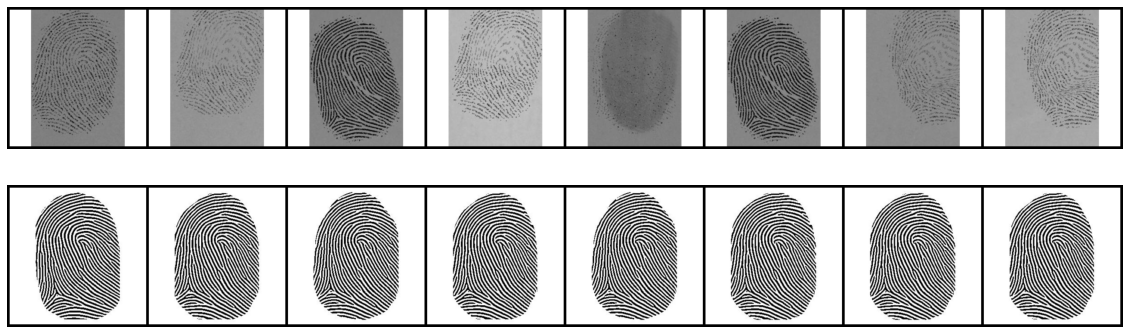

In [46]:
# Create the dataloader
#disp_dataset = dset.ImageFolder(root=data_dir)
disp_fingerprints = [str(finger) for finger in range(1,1000+1)]
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints, batch_size)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=10,
                                         shuffle=shuffle, num_workers=1)

# Get a Batch of Sample Images
real_batch = next(iter(disp_dataloader))
batch = real_batch

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


## Weight Initialization

In [54]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [55]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(ResNetBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        out = torch.relu(self.bn(self.conv(x)))
        out = self.bn(self.conv(out))
        out += x
        out = F.relu(out)
        return out
    

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1   = nn.Conv2d(nc, ngf, 7, 1, 3, bias=False)
        self.conv2   = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)
        self.conv3   = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.conv4   = nn.Conv2d(ngf * 4, ngf * 8, 4, 2, 1, bias=False)
        self.conv5   = nn.Conv2d(ngf, nc, 7, 1, 3, bias=False)
        # Transpose Convolutional Layers
        self.deconv1 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        # ResNet Layer
        self.resNet = ResNetBlock(ngf * 4, ngf * 4)
        # Batch Normalization Layers
        self.bn0 = nn.BatchNorm2d(ngf)
        self.bn1 = nn.BatchNorm2d(ngf * 2)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.bn3 = nn.BatchNorm2d(ngf * 8)


    def forward(self, x):
        out = F.relu(self.bn0(self.conv1(x)), True)
        out = F.relu(self.bn1(self.conv2(out)), True)
        out = F.relu(self.bn2(self.conv3(out)), True)
        out = F.relu(self.bn3(self.conv4(out)), True)
        out = F.relu(self.bn2(self.deconv1(out)), True)
        out = F.relu(self.bn1(self.deconv2(out)), True)
        out = F.relu(self.bn0(self.deconv3(out)), True)
        out = torch.tanh(self.conv5(out))
        return out

In [56]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (conv1): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (deconv1): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (resNet): ResNetBlock(
    (conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn0): Ba

## Discriminator

In [57]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        # Convolutional Layers
        self.conv1   = nn.Conv2d(nc, ngf, 7, 1, 3, bias=False)
        self.conv2   = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)
        self.conv3   = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.conv4   = nn.Conv2d(ngf, nc, 7, 1, 3, bias=False)
        # Transpose Convolutional Layers
        self.conv5 = nn.Conv2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.conv6 = nn.Conv2d(ngf * 2, nc, 4, 2, 1, bias=False)
        # ResNet Layer
        self.resNet = ResNetBlock(ngf * 4, ngf * 4)
        # Batch Normalization Layers
        self.bn0 = nn.BatchNorm2d(ngf)
        self.bn1 = nn.BatchNorm2d(ngf * 2)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.bn3 = nn.BatchNorm2d(ngf * 8)
        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 32)
        self.fc2 = nn.Linear(256, 1)


    def forward(self, x):
        out = F.leaky_relu_(self.bn0(self.conv1(x)), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv5(out)), 0.2)
        out = F.leaky_relu_(self.conv6(out))
        out = out.view(out.shape[0], -1)
        #print(out.shape)
        #out = F.leaky_relu_(self.fc1(out), 0.2)
        #out = F.relu(self.fc2(out), 0.2)
        #out = self.fc1(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

In [58]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (conv5): Conv2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv6): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (resNet): ResNetBlock(
    (conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0

## Set Training Params

In [59]:
# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
test_batch = []
test = next(iter(test_loader))
test_batch.append(test[0].to(device))     
test_batch.append(test[1].to(device))

criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for both G, D, and S
optimizerD = optim.Adam(netD.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=glr, betas=(beta1, 0.999))


## GAN Training


[*] Train on 10000 sample pairs

Epoch: 1/50


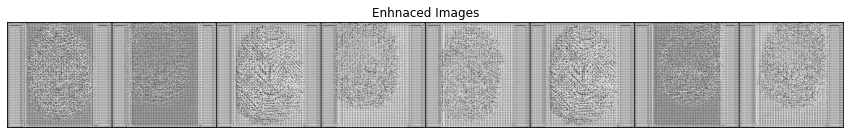

  0%|          | 0/10000 [00:03<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f305cf00f70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1445, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x900 and 1225x1)

In [53]:
# Train

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

errS = 0
iters = 0
# switch to train mode
netG.train()
netD.train()
# Load checkpoint
if os.path.isfile(model_ckpt_file):
    checkpoint = torch.load(model_ckpt_file)
    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    img_list = checkpoint['img_list']
    test_batch = checkpoint['test_batch']
    iters = checkpoint['iters']
    start_epoch = checkpoint['epoch']

print("\n[*] Train on {} sample pairs".format(
    num_train, num_valid)
)

gLossMvAvg = MovingAvg()

for epoch in range(1, num_epochs+1):
    print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
    train_batch_time = AverageMeter()
    train_losses = AverageMeter()
    matching_correct = 0
    total_matched = 0
    tic = time.time()
    with tqdm(total=num_train) as pbar:
        for i, (x1, enhanced_x1) in enumerate(train_loader): 
            x1, enhanced_x1 = x1.to(device), enhanced_x1.to(device)

            ############################
            # Update D network
            ###########################
            ## Train with all-Gabor Enhanced batch
            netD.zero_grad()
            # Format batch
            b_size = enhanced_x1.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(enhanced_x1)
            output = output.view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
            
            ## Train with all-GAN_Enhanced batch
            GAN_Enhanced = netG(x1)
            label.fill_(fake_label)
            # Classify all GAN_Enhanced batch with D
            output = netD(GAN_Enhanced.detach()).view(-1)
            # Calculate D's loss on the all-GAN_Enhanced batch
            errD_GAN_Enhanced = criterion(output, label)
            # Calculate the gradients for this batch
            errD_GAN_Enhanced.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-GAN_Enhanced batches
            errD = errD_real + errD_GAN_Enhanced
            # Update D
            optimizerD.step()
            
            
            ############################
            # Update G network
            ############################
            netG.zero_grad()
            label.fill_(real_label)  # GAN_Enhanced labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-GAN_Enhanced batch through D
            output = netD(GAN_Enhanced).view(-1)
            # Calculate G's loss based on this output
            errG_quality = criterion(output, label)
            # Calculate gradients for G
            errG_quality.backward()
            D_G_z2 = output.mean().item()

            # Add the gradients
            errG = errG_quality 

            # Update G
            optimizerG.step()
            
            # store batch statistics
            toc = time.time()
            train_batch_time.update(toc-tic)
            tic = time.time()
            pbar.set_description(
                (
                    "loss_D: {:.12f}  loss_G: {:.6f}".format(
                        errD.item(), errG.item()
                    )
                )
            )
            pbar.update(batch_size)
            
            gLossMvAvg.push(errG.item())
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 50000 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = netG(test_batch[0]).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                #saveCkpt(model_ckpt_file, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters)

            iters += 1   
        # Plot the fake images from the last epoch
        #saveCkpt(model_ckpt_file, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters)
        plotFigures(netG, test_batch)
# Save results
#saveCkpt(model_ckpt_file, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters)

## Results

### Training Loss

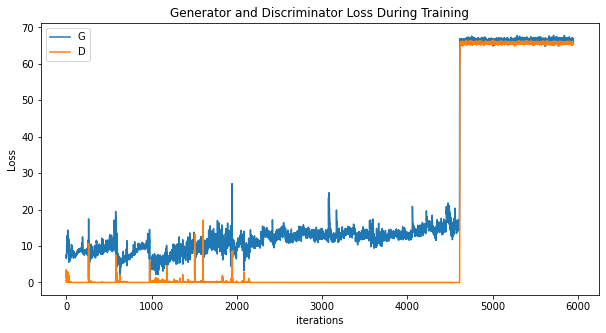

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Animation of Generator Progression.

Below is an animation of the generator's progression throughout training. Note, for each frame, the generator was fed the same batch of sample images as input.

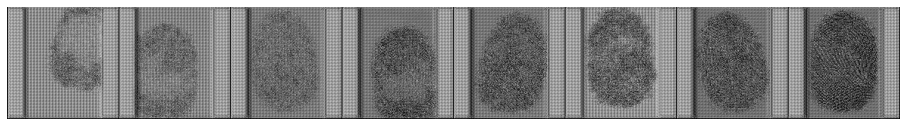

In [55]:
#%%capture
fig = plt.figure(figsize=(16,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Side by Side Comparison of Real and Fake Images
* Left: Real Images
* Middle: Generated Images
* Right: Real Images

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(test_loader))

# Plot the noisy images
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(3,1,2)
plt.axis("off")
plt.title("Enhnaced Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

# Plot the real images
plt.subplot(3,1,3)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[1].to(device)[:], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()